In [233]:
## Grabbing historical POA Data. Plane of Array data is the best estimate of energy that panels could actually see
import requests
import pandas as pd
import numpy as np 

# Define the URL for the PVGIS API
url = "https://re.jrc.ec.europa.eu/api/seriescalc"

# Define the parameters (change the values to your required ones)
params = {
    "lat": 42.5406,          # Latitude of the location (Walled Lake, MI)
    "lon": -83.4802,         # Longitude of the location (Walled Lake, MI)
    "startyear": 2006,       # Start year
    "endyear": 2006,         # End year
    "outputformat": "json",  # Request the data in JSON format
    "angle": 30,             # typical angle with horizon on rooftop
    "aspect": 90,            # compass direction your solar panel is facing.
    "mountingplace": "free", # no shading
    "temperature": 0,        # Temperature data as well (optional)
}

# Send the API request to PVGIS. PVGIS uses models (like Hay–Davies or Perez) to compute POA irradiance
response = requests.get(url, params=params)

# Check the response status
if response.status_code == 200:
    data = response.json()
    
    # Extract the solar data (specifically GHI, and other solar parameters)
    data = data["outputs"]["hourly"]  # GHI data

    # Convert the data into a pandas DataFrame for easier processing
    df = pd.DataFrame(data)

    print("Data successfully loaded")
else:
    print(f"Error: {response.status_code}")
    print(response.text)  

Data successfully loaded


In [234]:
## Convert the hourly POA into average for each day
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

# Group by date and calculate average G(i)
df["Date"] = df["time"].dt.date
daily_avg = df.groupby("Date")[["G(i)"]].mean().reset_index()

# Parameters
area_m2 = 26.5
efficiency = 0.18

# (W) = (W/m² * m² * efficiency) wattage produced on average throughout the day
daily_avg['G(i)'] = (daily_avg['G(i)'] * area_m2 * efficiency)

In [235]:
## Loading in a sample of real time MI solar farm production data. The data came from https://www.nrel.gov/grid/solar-power-data
solar_sample = pd.read_csv('Actual_42.55_-85.35_2006_DPV_15MW_5_Min.csv')
system_size = 5000 #wattage of system size you would like to scale to
solar_sample['Power(W)'] = solar_sample['Power(MW)'] * 1000000 * (system_size/15000000) #adjusting the system size to 5000 kW linearly

## grabbing average daily solar data from current season. wattage produced on average throughout the day
solar_sample['LocalTime'] = pd.to_datetime(solar_sample['LocalTime'], format='%m/%d/%y %H:%M')
solar_sample['LocalTime'] = solar_sample['LocalTime'].dt.date
daily_avg_solar = solar_sample.groupby("LocalTime")[["Power(W)"]].mean().reset_index()

size of system to consider (in watts):  5000


In [236]:
#looking to see approximately how close live data of a solar farm is to modeled data 
from sklearn.metrics import r2_score
r2 = r2_score(daily_avg_solar['Power(W)'], daily_avg['G(i)'])
print(f"R-squared: {r2}")

R-squared: 0.6065919570909541


In [237]:
## Grabbing historical POA Data. Plane of Array data is the best estimate of energy that panels would actually seee
import requests
import pandas as pd
import numpy as np 

# Define the URL for the PVGIS API
url = "https://re.jrc.ec.europa.eu/api/seriescalc"

# Define the parameters (change the values to your required ones)
params = {
    "lat": 42.5406,          # Latitude of the location (Walled Lake, MI)
    "lon": -83.4802,         # Longitude of the location (Walled Lake, MI)
    "startyear": 2014,       # Start year
    "endyear": 2020,         # End year
    "outputformat": "json",  # Request the data in JSON format
    "angle": 30,             # typical angle with horizon on rooftop
    "aspect": 90,            # compass direction your solar panel is facing.
    "mountingplace": "free", # no shading
    "temperature": 0,        # Temperature data as well (optional)
}

# Send the API request to PVGI.
# PVGIS uses internal models (like Hay–Davies or Perez) to compute POA irradianc
response = requests.get(url, params=params)

# Check the response status
if response.status_code == 200:
    data = response.json()
    
    # Extract the solar data (specifically GHI, and other solar parameters)
    data = data["outputs"]["hourly"]  # GHI data

    # Convert the data into a pandas DataFrame for easier processing
    df = pd.DataFrame(data)

    print("Data successfully loaded")
else:
    print(f"Error: {response.status_code}")
    print(response.text)  # Display the error message

Data successfully loaded


In [238]:
## Converting hourly POA data to Daily total
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

# Group by date and calculate average G(i)
df["Date"] = df["time"].dt.date
daily_avg = df.groupby("Date")[["G(i)"]].mean().reset_index()

# Parameters
area_m2 = 26.5
efficiency = 0.18

# Energy (kWh) = (W/m² * m² * efficiency * hr) / 1000 W
daily_avg['G(i)'] = (daily_avg['G(i)'] * area_m2 * efficiency * 24) / 1000

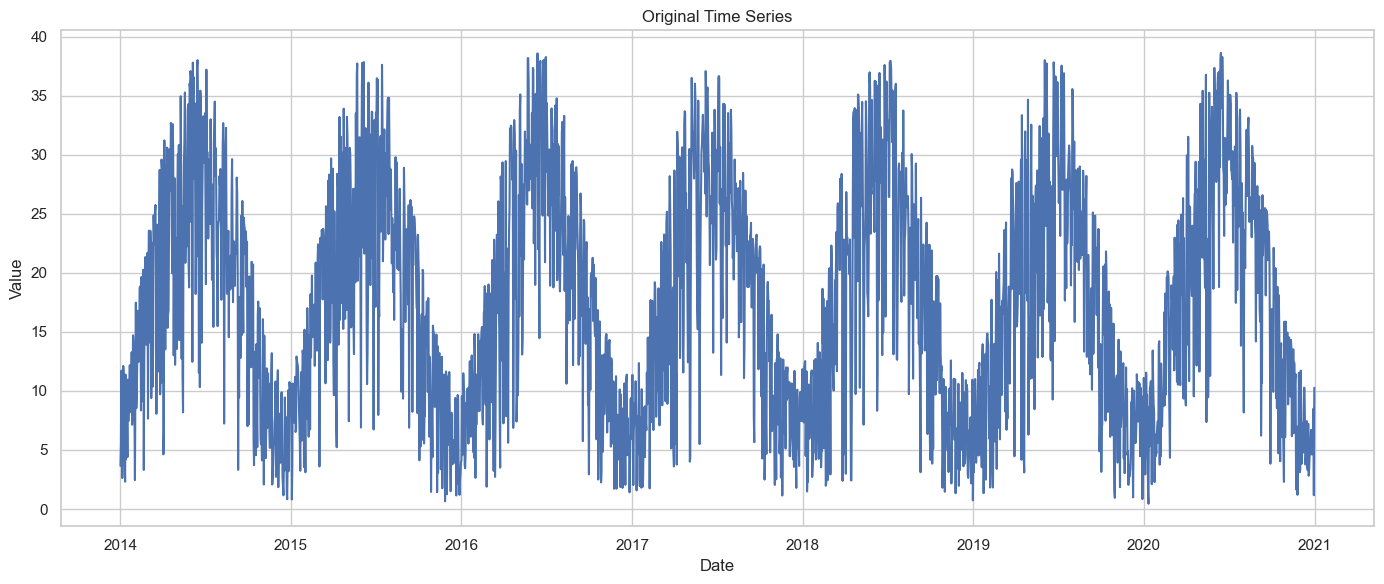

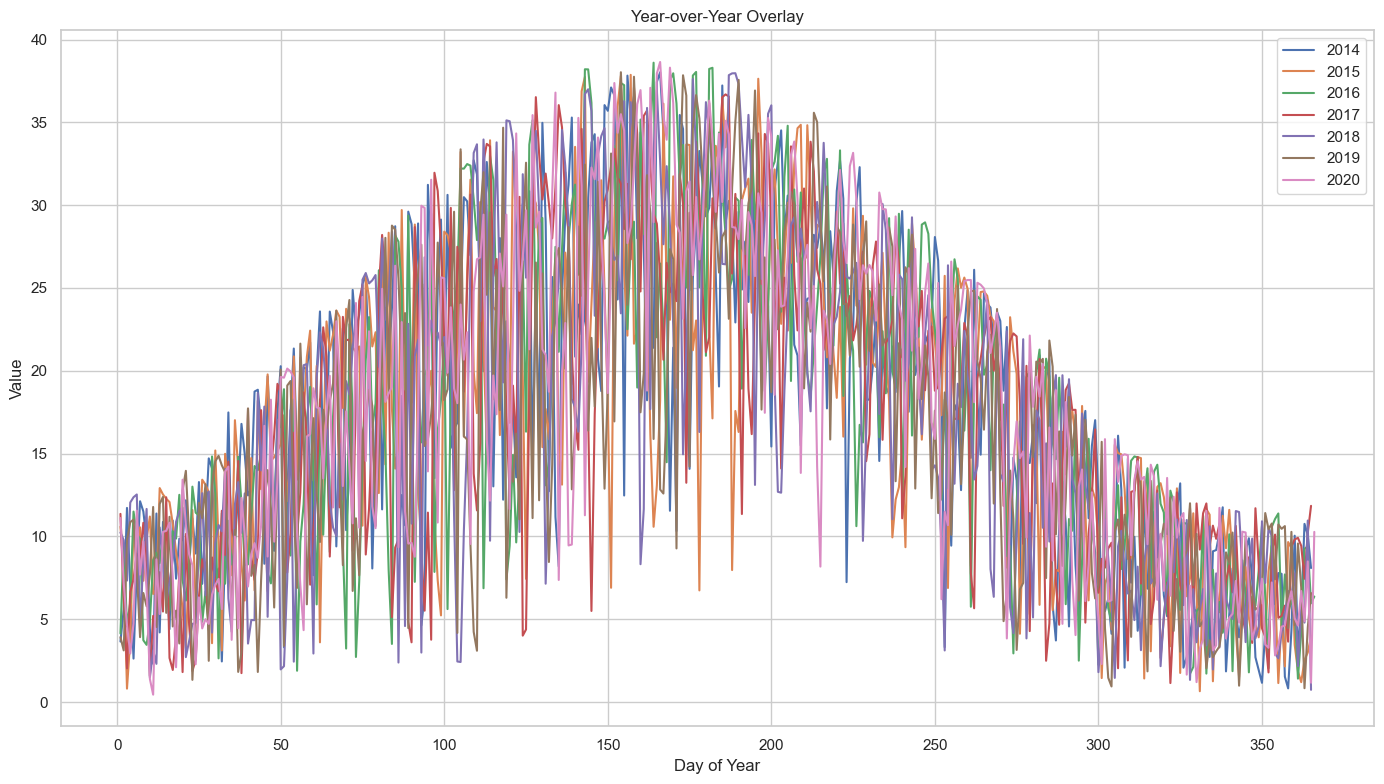

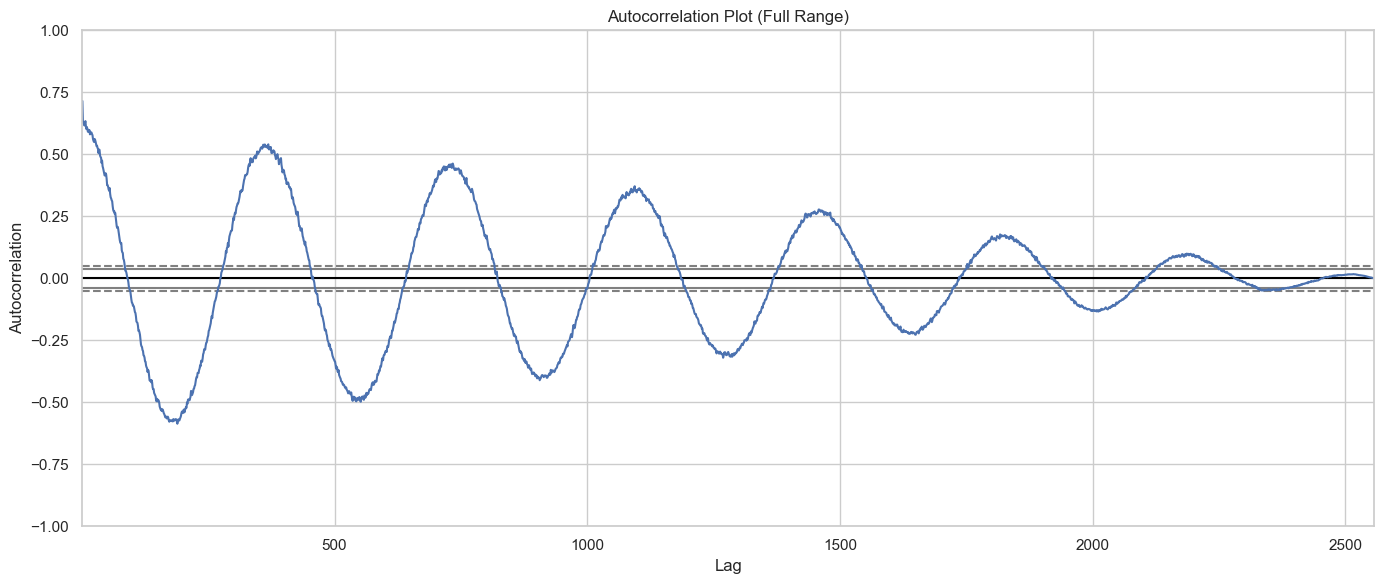

<Figure size 1400x600 with 0 Axes>

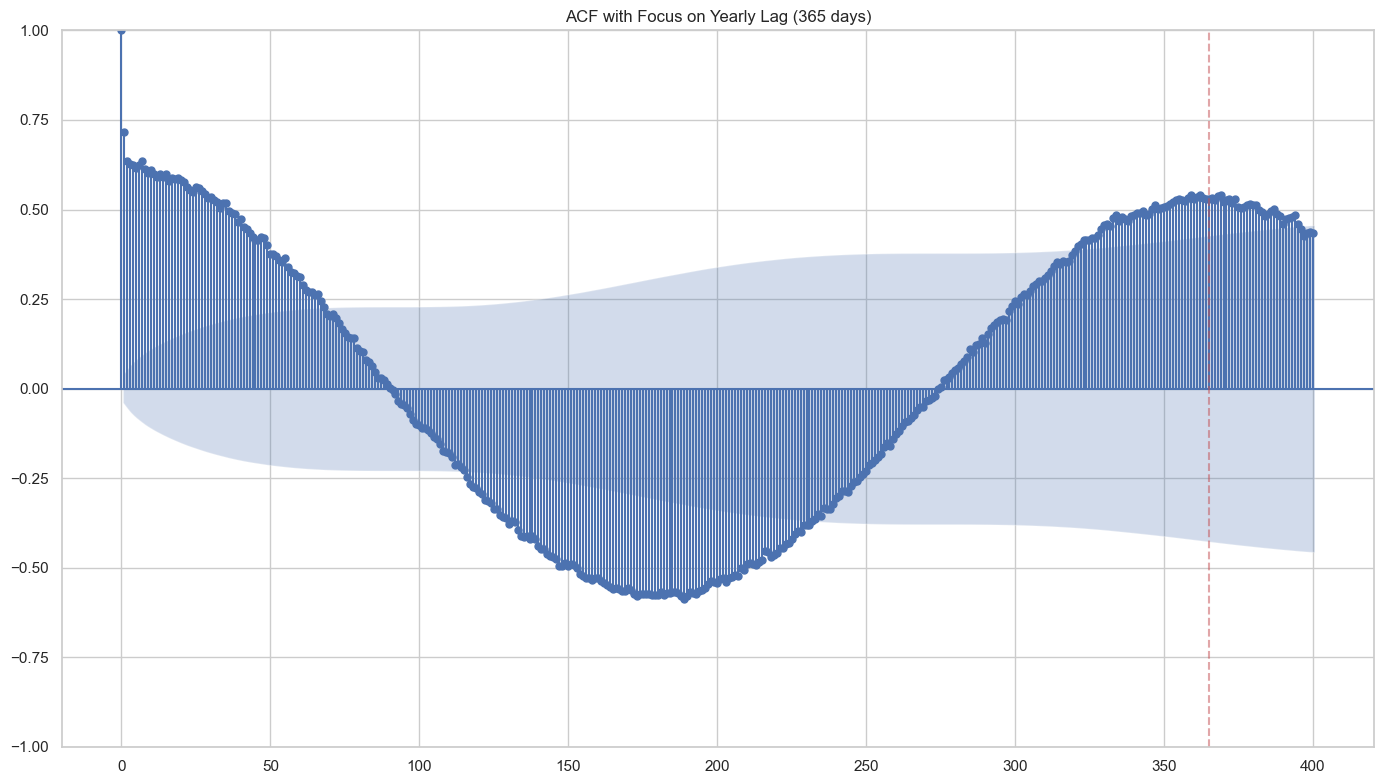

ADF Statistic: -8.427327324427466
p-value: 1.9111963449314596e-13
Critical Values: {'1%': -3.4333712566259007, '5%': -2.8628746849930136, '10%': -2.567480519733324}
Series is stationary after yearly differencing


/Users/crorick/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


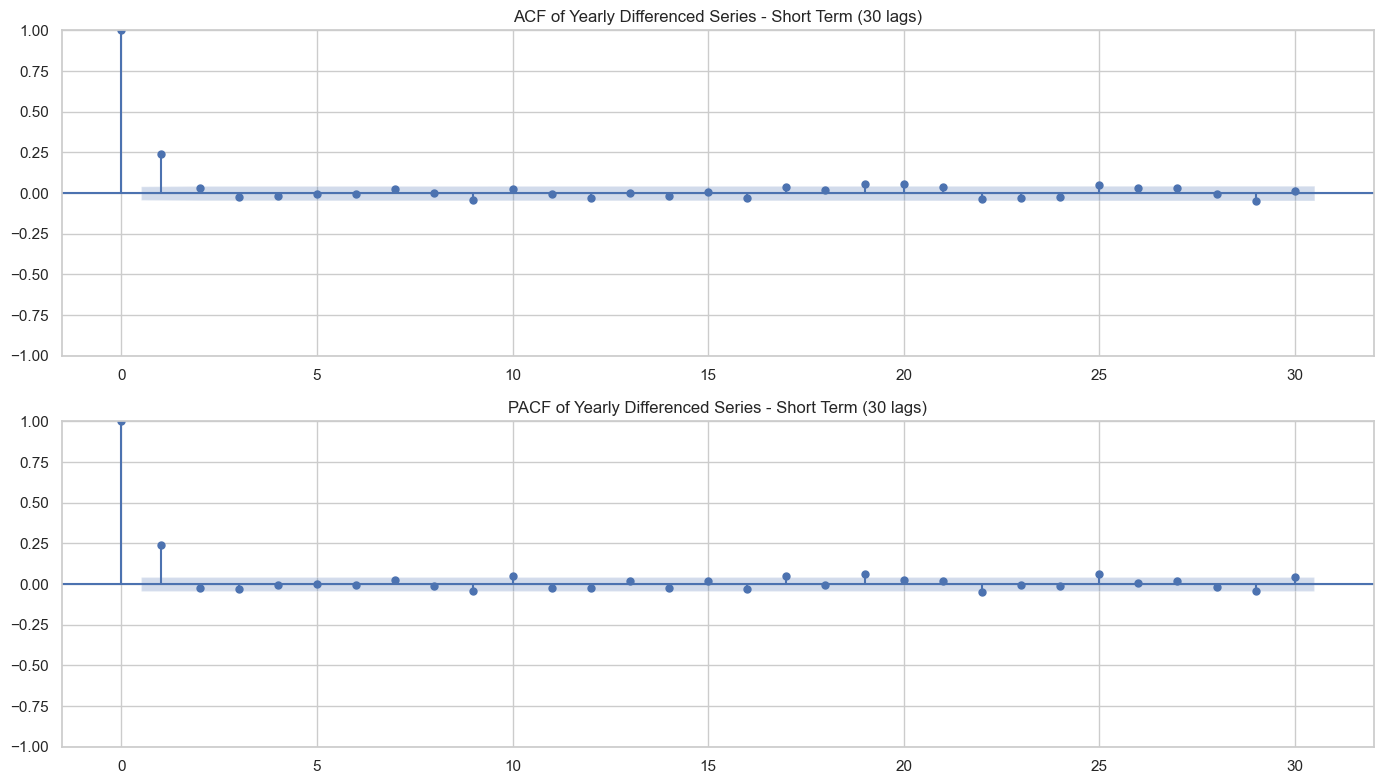

In [239]:
##plotting various visuals to determine appropriate model for forecast
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import boxcox
import matplotlib.dates as mdates
from pandas.plotting import autocorrelation_plot

# Set style for better visualization
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (14, 8), 'font.size': 12})

# First, check if 'date' is already the index or if it's a column
daily_avg = daily_avg.set_index('Date')

# Make sure the index is datetime and set frequency
daily_avg.index = pd.to_datetime(daily_avg.index)
daily_avg = daily_avg.asfreq('D')  # Set daily frequency

ts = daily_avg

# 1. VISUAL INSPECTION METHODS

# 1.1 Time Series Plot
plt.figure(figsize=(14, 6))
plt.plot(ts)
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 1.2 Year-over-Year Overlay Plot
plt.figure(figsize=(14, 8))
years = ts.index.year.unique()
for year in years:
    year_data = ts[ts.index.year == year]
    # Reset index to day of year for overlay
    year_data.index = year_data.index.dayofyear
    plt.plot(year_data, label=str(year))
plt.title('Year-over-Year Overlay')
plt.xlabel('Day of Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. STATISTICAL TESTS AND ANALYSES

# 2.1 Autocorrelation Analysis
plt.figure(figsize=(14, 6))
autocorrelation_plot(ts)
plt.title('Autocorrelation Plot (Full Range)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2.2 ACF with Focus on Yearly Lags
plt.figure(figsize=(14, 6))
plot_acf(ts, lags=400)  # Slightly more than a year of lags
plt.axvline(x=365, color='r', linestyle='--', alpha=0.5)
plt.title('ACF with Focus on Yearly Lag (365 days)')
plt.tight_layout()
plt.show()

# 3. YEARLY SEAONALITY

# Apply yearly differencing (lag=365 for daily data)
ts_yearly_diff = ts.diff(365).dropna()

# Check if differencing made the series stationary
adf_result = adfuller(ts_yearly_diff.dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")
is_stationary = adf_result[1] < 0.05
print(f"Series is {'stationary' if is_stationary else 'non-stationary'} after yearly differencing")

# Plot ACF and PACF of the differenced series with different lag ranges
# 3.1 Short-term patterns (up to 30 lags)
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(ts_yearly_diff.dropna(), lags=30, ax=axes[0])
axes[0].set_title('ACF of Yearly Differenced Series - Short Term (30 lags)')
plot_pacf(ts_yearly_diff.dropna(), lags=30, ax=axes[1])
axes[1].set_title('PACF of Yearly Differenced Series - Short Term (30 lags)')
plt.tight_layout()
plt.show()

In [240]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import pandas as pd
import matplotlib.pyplot as plt

# Create Fourier seasonal terms
fourier = CalendarFourier(freq='A', order=4)  # annual seasonality, 3 harmonics
dp = DeterministicProcess(index=daily_avg.index, constant=True,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)

# use fourier as input into a SARIMAX model
X = dp.in_sample()
model = SARIMAX(daily_avg['G(i)'], order=(1, 0, 1), exog=X)
result = model.fit()
print(result.summary())

# Forecast 5 years ahead
n_forecast = 1825
X_future = dp.out_of_sample(steps=n_forecast)

# Using 'result' variable for consistency
forecast = result.get_forecast(steps=n_forecast, exog=X_future)
forecast_ci = forecast.conf_int()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15587D+00    |proj g|=  1.82298D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      1     18      1     0     0   1.823D-01   3.156D+00
  F =   3.1558746578628045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                   G(i)   No. Observations:                 2557
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -8069.572
Date:                Fri, 27 Jun 2025   AIC                          16165.143
Time:                        14:10:38   BIC                          16241.149
Sample:                    0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


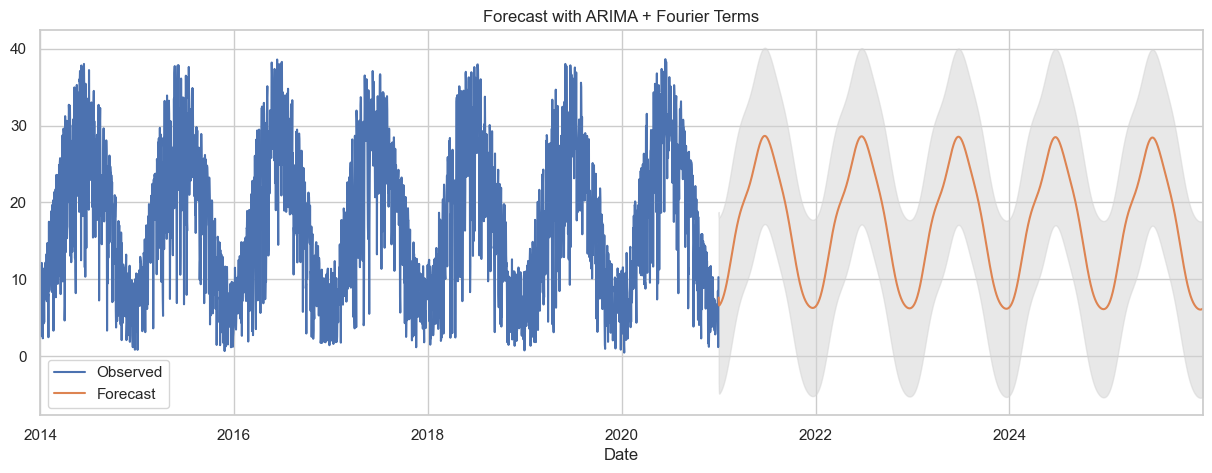

In [241]:
# Plot forecast
plt.figure(figsize=(15,5))
daily_avg['G(i)'].plot(label='Observed')
forecast.predicted_mean.plot(label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='lightgrey', alpha=0.5)
plt.legend()
plt.title('Forecast with ARIMA + Fourier Terms')
plt.show()

In [243]:
# Load local CSV of electricity prices
df_prices = pd.read_excel("state_electricity_prices.xlsx", skiprows=2)

# Get electricity price from lat/lon
def get_electricity_rate(lat, lon, symbol):
    state_name = symbol
    if not state_name:
        return None
    match = df_prices[df_prices["State"] == state_name]
    if not match.empty:
        return match[['Year', 'Cents/kWh']]
    else:
        return None

# two letter abbreviation of michigan to pull electricity rates
state_code = 'MI'

# getting the electricity rate from the csv of electricity rates based on the 2 letter abbreviation
price = get_electricity_rate(params['lat'], params['lon'], state_code)

In [253]:
#to ease calculations, rates grouped to a yearly average
price = price.groupby('Year')['Cents/kWh'].mean().reset_index()

# Create daily date range to assign the yearly rates to
daily_dates = pd.date_range(start='2021-01-01', end='2025-12-30', freq='D')
df_daily = pd.DataFrame(index=daily_dates)

# Map each day to its corresponding year
df_daily['Year'] = df_daily.index.year

# Merge the yearly rate into the daily dataframe
price_daily_forecast = df_daily.merge(price, on='Year', how='left')

# Create daily date range
daily_dates = pd.date_range(start='2014-01-01', end='2020-12-31', freq='D')
df_daily = pd.DataFrame(index=daily_dates)

# Map each day to its corresponding year
df_daily['Year'] = df_daily.index.year

# Merge the yearly rate into the daily frame
price_daily_historical = df_daily.merge(price, on='Year', how='left')

In [260]:
#dollar amount per day in energy historical
Daily_energy_return_historical = daily_avg['G(i)'] * price_daily_historical['Cents/kWh'].values / 100

#dollar amount per day in energy forecast
Daily_energy_return_forecast = forecast.predicted_mean.values * price_daily_forecast['Cents/kWh'].values / 100

print(f'Total $ value of all solar energy produced by a 5 kW system in Walled Lake Michigan from 2014-2025: ${sum(Daily_energy_return_historical) + sum(Daily_energy_return_historical)}')


Total $ if all solar energy produced is used on a 5 kW system in Walled Lake Michigan from 2014-2025: $13724.262735293585
